In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

## Read in Keck pupil

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [6]:
screen1 = np.zeros(pupil.pupil.shape)

In [7]:
###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 10.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)
print(wav)
print(I_lam)

####set this up as a Target
targ = Target(wav,I_lam)

[0.05     0.05001  0.05002  ... 5.499925 5.49995  5.499975]
[1.2782356e-15 1.2860823e-15 1.2958241e-15 ... 1.2565724e-08 1.2565280e-08
 1.2564963e-08]


[1.02178835e-12 9.36697089e-13 1.59604946e-12 2.44948276e-12
 3.67535073e-12 6.01988878e-12 9.75313868e-12 2.35370507e-11
 6.04885237e-11 1.51556959e-10 2.99887252e-10 8.91091460e-10
 5.26157297e-09 4.73532330e-08 6.99514211e-07 6.72755826e-03
 3.53586039e-05 6.05094321e-03 8.01707326e-05 5.92120684e-05
 2.16502341e-04 4.05039646e-03 1.78752905e-04 1.24727994e-04
 2.35156505e-04 2.16905072e-03 1.78449549e-03 3.61757831e-04
 3.09299134e-04 5.12379790e-04 2.11642891e-03 1.94094937e-02
 1.82865242e-03 9.63481545e-04 1.01845811e-03 1.88518034e-03
 7.61747363e-03 3.12138129e-02 6.30836897e-03 3.48035434e-03
 3.37743909e-03 5.37829467e-03 1.30158515e-02 5.65561221e-02
 4.31994150e-02 1.86533513e-02 1.43848392e-02 1.55815408e-02
 2.57526230e-02 5.89916262e-02 1.62212829e-01 1.72403007e-01
 1.00243989e-01 8.39560102e-02 8.73714382e-02 1.12833634e-01
 2.30204183e-01 4.62843415e-01 7.92944362e-01 6.79750687e-01
 6.03258898e-01 5.25599772e-01 5.11957706e-01 5.71164932e-01
 7.51500207e-01 1.068859

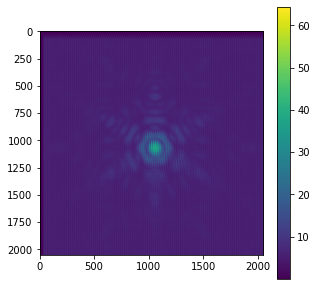

5.5587741533915205
[2.03866425e+04 2.78554899e+04 6.70803395e+04 1.36902598e+05
 2.61234759e+05 5.19769494e+05 1.00826366e+06 2.81632986e+06
 7.95802139e+06 2.00507033e+07 3.12540723e+07 4.39218454e+07
 6.55341697e+07 8.65786722e+07 8.54180669e+07 7.34601093e+07
 7.00743241e+07 7.28628247e+07 8.15801457e+07 8.20116377e+07
 8.16047284e+07 8.05963036e+07 7.96262940e+07 7.88602800e+07
 7.78558700e+07 7.60333908e+07 7.16735637e+07 6.80132712e+07
 7.21202309e+07 7.20603798e+07 7.00660765e+07 7.06592803e+07
 6.97173734e+07 6.89205777e+07 6.81743387e+07 6.71723104e+07
 6.54440343e+07 6.50617029e+07 6.30836897e+07 6.26591267e+07
 6.06207016e+07 6.16013352e+07 5.79472839e+07 5.89808219e+07
 5.69739911e+07 5.54466589e+07 5.57627430e+07 5.25135666e+07
 5.36512980e+07 5.33109511e+07 5.32362908e+07 5.24169392e+07
 4.98166830e+07 5.20739810e+07 4.92594143e+07 4.46329818e+07
 4.95746728e+07 4.56337584e+07 4.40375315e+07 3.91154781e+07
 4.20997699e+07 3.75156359e+07 3.01963078e+07 2.27772250e+07
 1.70

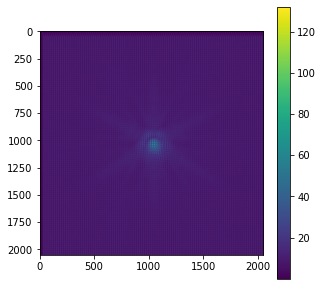

2.102834447224935
[3.68924543e+03 5.27659059e+03 2.45768485e+04 9.66371279e+04
 1.11163727e+05 1.54429451e+05 3.43995837e+05 1.70440712e+06
 8.10924270e+06 1.90152209e+07 3.16336764e+07 4.77709386e+07
 6.31792458e+07 8.42816870e+07 8.40998869e+07 7.21025303e+07
 6.86456936e+07 7.07176248e+07 7.93416661e+07 8.05083694e+07
 8.01058660e+07 7.89498010e+07 7.84887755e+07 7.80555832e+07
 7.68230881e+07 7.51782095e+07 7.15266916e+07 6.82231887e+07
 7.21202309e+07 7.21347455e+07 7.04994749e+07 7.12408382e+07
 6.97888052e+07 6.84986149e+07 6.77586416e+07 6.68320251e+07
 6.49803620e+07 6.42714798e+07 6.24438957e+07 6.24678985e+07
 6.08062752e+07 6.17274383e+07 5.79472839e+07 5.91020569e+07
 5.74429128e+07 5.60741416e+07 5.62212240e+07 5.26753127e+07
 5.37613519e+07 5.35294386e+07 5.35628938e+07 5.26311044e+07
 4.98675682e+07 5.19677076e+07 4.92092008e+07 4.47694741e+07
 4.97766063e+07 4.57266988e+07 4.39479333e+07 3.89564721e+07
 4.20569856e+07 3.75918098e+07 3.03189324e+07 2.28234732e+07
 1.705

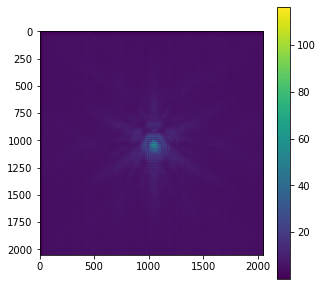

3.3325623154640196
[2.89342951e-02 5.27659059e-02 1.12764364e-01 4.35538167e-02
 1.95926069e-02 1.32980916e-02 1.12688291e-02 1.75310447e-02
 3.42138212e-02 4.98914213e-02 1.92332753e-02 7.59273197e-03
 5.92768003e-03 6.12234896e-03 5.99332527e-03 6.27503192e-03
 8.78607733e-03 1.40547581e-02 1.56693573e-02 9.68772910e-03
 5.98712242e-03 4.33030191e-03 3.72131047e-03 3.79816859e-03
 4.52040715e-03 6.22727464e-03 9.32637560e-03 1.29449127e-02
 1.35318371e-02 9.66754322e-03 6.69600545e-03 5.44483549e-03
 4.96450559e-03 5.16904332e-03 6.12460523e-03 8.23490330e-03
 1.22541967e-02 2.00848374e-02 2.90466482e-02 3.07240072e-02
 2.41864228e-02 1.95459713e-02 1.58686408e-02 1.55180785e-02
 1.58847238e-02 1.77976930e-02 2.20643947e-02 2.67420216e-02
 3.51622353e-02 4.29874165e-02 4.90448855e-02 5.18815261e-02
 5.19029792e-02 5.73876526e-02 6.02561643e-02 6.41513806e-02
 8.73362362e-02 1.03628596e-01 1.31261411e-01 1.52248253e-01
 2.04936888e-01 2.13286864e-01 1.88841884e-01 1.52618970e-01
 1.23

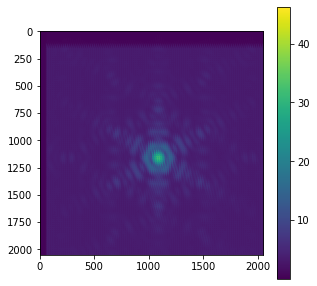

35.71320613225301
[1.46882075e-04 1.93474988e-04 3.97277528e-04 5.03989466e-04
 4.21727390e-04 3.15293462e-04 2.16809637e-04 2.11833456e-04
 2.09819566e-04 1.88269514e-04 1.20207970e-04 9.91273341e-05
 1.30530071e-04 1.83758815e-04 2.02999727e-04 2.00620011e-04
 2.25723613e-04 2.87012954e-04 4.07071662e-04 5.35330548e-04
 7.18621231e-04 9.87901576e-04 1.40564784e-03 2.07611757e-03
 3.20162404e-03 5.09221584e-03 8.15139915e-03 1.37146102e-02
 2.57253607e-02 4.28346530e-02 5.89421839e-02 6.86965225e-02
 6.85744657e-02 6.61074929e-02 6.49873270e-02 6.62195117e-02
 6.95508462e-02 7.83637920e-02 8.89313678e-02 1.06450398e-01
 1.28664346e-01 1.68978074e-01 2.10393215e-01 2.93994847e-01
 4.02100390e-01 5.70438877e-01 8.65382754e-01 1.25083649e+00
 2.00298179e+00 3.16260663e+00 5.06234667e+00 8.13827860e+00
 1.27722037e+01 2.25299673e+01 3.58524177e+01 5.18670737e+01
 7.57250603e+01 6.36642046e+01 4.00952093e+01 2.07105326e+01
 1.33059232e+01 7.61738800e+00 4.26120485e+00 2.42802906e+00
 1.454

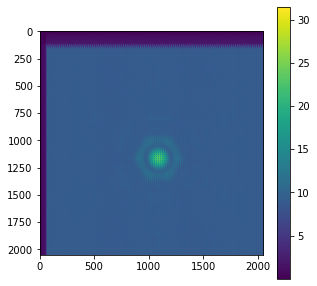

7.404981013139089
[3.40432368e+05 7.32178074e+05 2.59647176e+06 6.84512989e+06
 1.58408311e+07 3.56045678e+07 5.54215515e+07 7.88085387e+07
 9.26230518e+07 9.22520620e+07 6.20652731e+07 5.17782139e+07
 6.61397216e+07 8.68437090e+07 8.64726110e+07 7.42143199e+07
 7.03600502e+07 7.28628247e+07 8.16630524e+07 8.22621825e+07
 8.21043492e+07 8.11725795e+07 8.01950532e+07 7.94235677e+07
 7.84119834e+07 7.68108283e+07 7.25547960e+07 6.91328312e+07
 7.34585444e+07 7.35476942e+07 7.14385048e+07 7.19677855e+07
 7.07174177e+07 6.96238489e+07 6.85900359e+07 6.74445386e+07
 6.56427510e+07 6.52592587e+07 6.34035867e+07 6.32328115e+07
 6.13629959e+07 6.25471080e+07 5.90170799e+07 6.01931718e+07
 5.81462954e+07 5.65875366e+07 5.67943251e+07 5.34840432e+07
 5.46417835e+07 5.42395230e+07 5.41072322e+07 5.32200588e+07
 5.01219946e+07 4.94171453e+07 3.82626643e+07 2.26577216e+07
 1.36809942e+07 6.41289069e+06 3.14041807e+06 1.45490498e+06
 8.38572652e+05 4.07530258e+05 1.83936900e+05 7.90843751e+04
 3.480

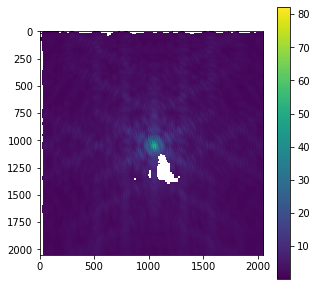

47.62347911596298


In [8]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs
    arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
    arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns
    
    lens = Lenslet(arg_spaxel)
    lens.get_shifts()
    lens.make_trace(phys=True,disp=True,verbose=True)
    
    nspax = arg_spaxel['no_spaxel']
    nlam = lens.trace.shape[0]

    keck_cube = np.zeros((nlam, nspax, nspax))
    mag1 = magn(lens.lmin)
    mag2 = magn(lens.lmax)

    psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
    if os.path.isfile(psf_file)==False:
        for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
            W = DFT_matrix(1600, mag)
            A = pupil.pupil * np.exp(1.j * screen1)
            out = abs(W.dot(A).dot(W))**2
            out /= np.sum(out, axis=(0,1))
            keck_cube[i] = frebin(out, (108, 108))
        fits.writeto(psf_file,np.array(keck_cube),clobber=True)
    else: keck_cube = pyfits.getdata(psf_file)

    vapor = 1 #PWV in mm
    airmass = 1 
    skybg = SkyBG(vapor,airmass)
    skytrans = SkyTrans(vapor,airmass)
    atmodisp = AtmoDispersion(90,20,600)

    telAO_emissivities = [0.4]
    telAO_temps = [285*u.K]
    scales_trans = [0.4]
    inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
    qe = QE()
    filt = Filter(lmin=lens.lmin,lmax=lens.lmax,fkw='asahi')
    dit = 1 ###integration time in seconds
    
    ####organize all these and pass to focal_plane 
    args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
    fp = FocalPlane(args_new)
    
    from time import time
    t1 = time()
    raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube,return_phots=True)
    rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_phot_s.fits'
    pyfits.writeto(rawfile,np.array(raw),clobber=True)
    rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    pyfits.writeto(rawfile,np.array(raw*0.8),clobber=True)
    

    f = plt.figure(figsize=(5,5))
    plt.imshow(raw**0.25)
    plt.colorbar()
    plt.show()
    t2 = time()
    print((t2-t1)/60.0)

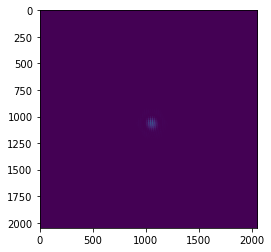

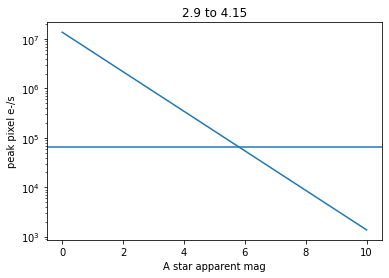

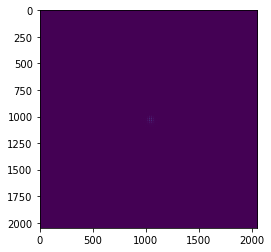

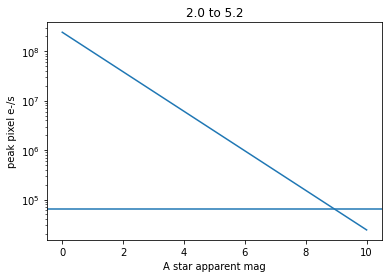

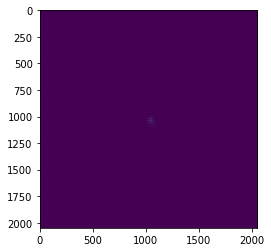

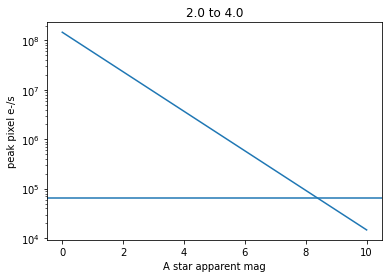

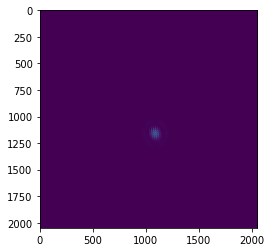

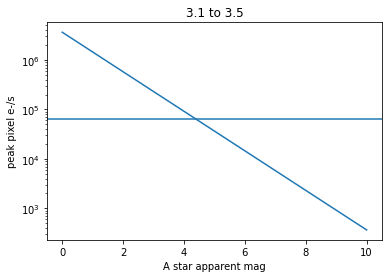

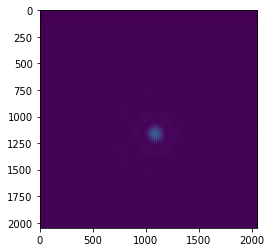

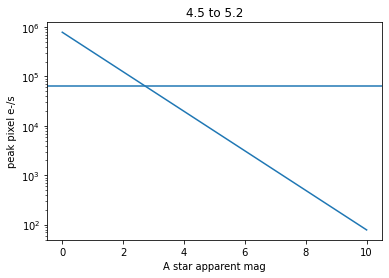

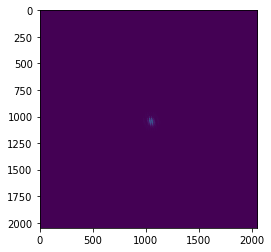

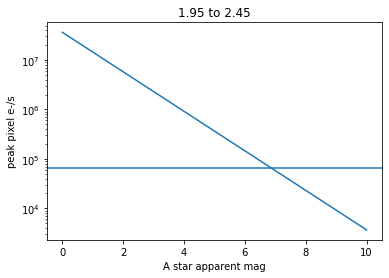

In [10]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    wav_min,wav_max = wavs 
    rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    im = pyfits.getdata(rawfile)
    
    plt.imshow(im)
    plt.show()
    
    mpixs = []
    f = plt.figure()
    plt.title(str(wav_min)+' to '+str(wav_max))
    amags = np.linspace(0.0,10.0,11)
    for amag in amags:
        im2 = im * 10**(-amag/2.5)
        mpix = np.max(im2)
        mpixs.append(mpix)
        
    plt.plot(amags,mpixs)
    plt.xlabel('A star apparent mag')
    plt.ylabel('peak pixel e-/s')
    plt.yscale('log')
    plt.axhline(65000)
    plt.show()